In [186]:
import os
import shutil
import random
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv
import matplotlib.pyplot as plt
import numpy as np
import cv2
import timm
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [187]:
train_path = r"C:\Users\Stepan\kaggle\dogs_vs_cats\data\train"
test_path = r"C:\Users\Stepan\kaggle\dogs_vs_cats\data\test"

In [188]:
train_list = glob.glob(os.path.join(train_path,'*.jpg'))
test_list =  glob.glob(os.path.join(test_path, '*.jpg'))
train_list[:3]

['C:\\Users\\Stepan\\kaggle\\dogs_vs_cats\\data\\train\\cat.0.jpg',
 'C:\\Users\\Stepan\\kaggle\\dogs_vs_cats\\data\\train\\cat.1.jpg',
 'C:\\Users\\Stepan\\kaggle\\dogs_vs_cats\\data\\train\\cat.10.jpg']

In [189]:
print(f'Train len: {len(train_list)}')
print(f'Test len: {len(test_list)}')

Train len: 25000
Test len: 12500


In [190]:
labels = [path.split('\\')[-1].split('.')[0] for path in train_list]

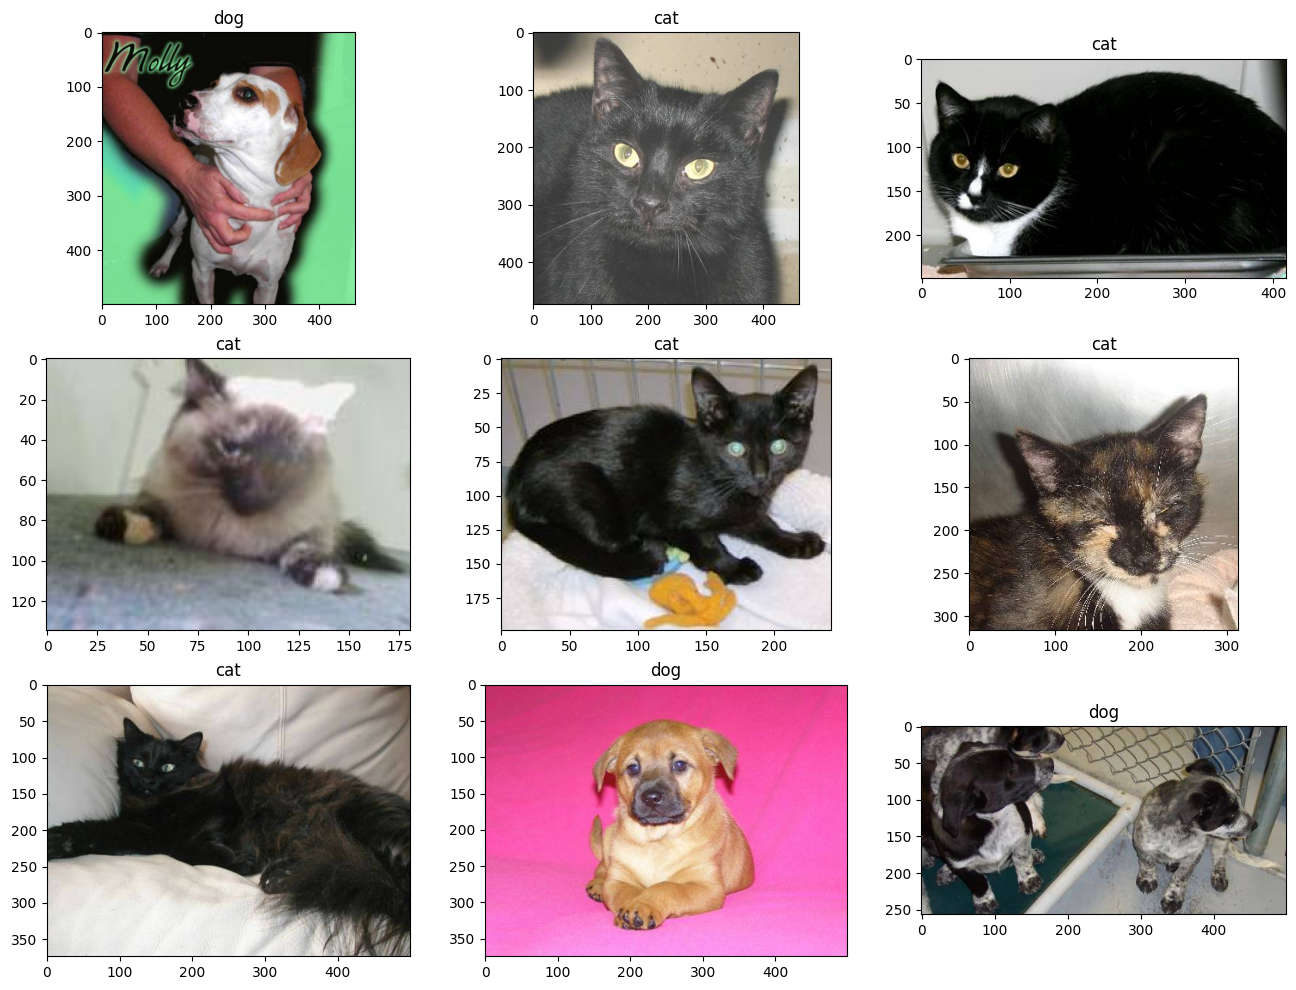

In [13]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = cv2.imread(train_list[random_idx[idx]], cv2.IMREAD_COLOR) #BGR -> RGB
    img = img[...,::-1]
    ax.set_title(labels[random_idx[idx]])
    ax.imshow(img)

### Use Sklearn to split the training data

In [191]:
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=0)

print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 20000
Validation Data: 5000
Test Data: 12500


In [192]:
image_height = 224
image_width = 224
image_channels = 3

In [193]:
train_transforms = transforms.Compose([
    # TODO: define traininig augmentations
    transforms.Resize((image_height, image_width)),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    #Maybe random horizontal flip
])

test_transforms = transforms.Compose([
    # TODO: define test augmentations
    transforms.Resize((image_height,image_width)),
    transforms.ToTensor()
])

In [194]:
class Dataset2catdogs(torch.utils.data.Dataset):
    
    def __init__(self, file_list: str, transform=None):
        self.files_path = file_list
        self.transform = transform
        self.filelength = len(file_list)
         
    def __len__(self):
        return self.filelength
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_path = self.files_path[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        lable = img_path.split('\\')[-1].split('.')[0]
        lable = 1 if lable == 'dog' else 0
        return img_transformed, lable

In [179]:
datasetcatdogs = Dataset2catdogs(train_list, transform=train_transforms)
datasetcatdogs[10][0]

tensor([[[0.5647, 0.5608, 0.5608,  ..., 0.3608, 0.3725, 0.4353],
         [0.5608, 0.5569, 0.5569,  ..., 0.3647, 0.4000, 0.4745],
         [0.5608, 0.5569, 0.5569,  ..., 0.3647, 0.4353, 0.5255],
         ...,
         [0.7451, 0.7647, 0.7804,  ..., 0.9765, 0.9373, 0.9255],
         [0.7412, 0.7529, 0.7765,  ..., 0.9765, 0.9412, 0.9294],
         [0.7529, 0.7373, 0.7647,  ..., 0.9765, 0.9451, 0.9333]],

        [[0.5765, 0.5725, 0.5725,  ..., 0.4157, 0.4235, 0.4863],
         [0.5725, 0.5686, 0.5686,  ..., 0.4196, 0.4510, 0.5255],
         [0.5725, 0.5686, 0.5686,  ..., 0.4196, 0.4863, 0.5765],
         ...,
         [0.7176, 0.7373, 0.7529,  ..., 0.9765, 0.9373, 0.9255],
         [0.7176, 0.7294, 0.7529,  ..., 0.9804, 0.9412, 0.9333],
         [0.7373, 0.7216, 0.7490,  ..., 0.9843, 0.9529, 0.9412]],

        [[0.6039, 0.6039, 0.6078,  ..., 0.4549, 0.4588, 0.5216],
         [0.6000, 0.6000, 0.6039,  ..., 0.4588, 0.4863, 0.5608],
         [0.6000, 0.6039, 0.6039,  ..., 0.4627, 0.5216, 0.

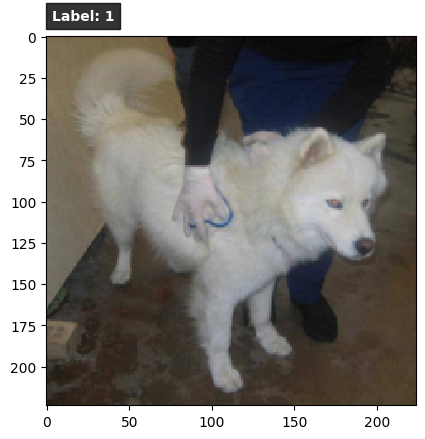

In [180]:
image, label = datasetcatdogs[random.randint(1, len(train_list))]

plt.imshow(image.permute(1, 2, 0), interpolation='nearest')
plt.text(3, -10, f'Label: {label}', color='white', fontsize=10, fontweight='bold', bbox=dict(facecolor='black', alpha=0.8))
plt.show()

In [195]:
train_data = Dataset2catdogs(train_list, transform=train_transforms)
valid_loader = Dataset2catdogs(valid_list, transform=train_transforms)
test_data = Dataset2catdogs(test_list, transform=test_transforms)

In [196]:
train_loader = DataLoader(dataset=train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset=valid_data, batch_size=32, shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=32, shuffle=False)

In [88]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [86]:
class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet, self).__init__()
        
        self.act = nn.LeakyReLU(0.2)
        self.maxpool = nn.MaxPool2d(2,2)
        
        self.conv0 = nn.Conv2d(3, 32, 3, stride=1, padding=0)
        self.conv1 = nn.Conv2d(32, 32, 3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1, padding=0)
        self.conv4 = nn.Conv2d(64, 64, 3, stride=1, padding=0)
        
        self.adaptivepool = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten()
        
        self.linear1 = nn.Linear(64, 10)
        self.linear2 = nn.Linear(10, 2)
        
    def forward(self, x):
        
        out = self.conv0(x)
        out = self.act(out)
        out = self.maxpool(out)
        
        out = self.conv1(out)
        out = self.act(out)
        out = self.maxpool(out)
        
        out = self.conv2(out)
        out = self.act(out)
        out = self.maxpool(out)
        
        out = self.conv3(out)
        out = self.act(out)
        
        out = self.adaptivepool(out)
        out = self.flatten(out)
        out = self.linear1(out)
        out = self.act(out)
        out = self.linear2(out)
        
        return out
        

In [87]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [133]:
#model = CNNNet().to(device)
#loss_fn = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


def train(epoch):
    model.train()
    for batch_inx, (image, lable) in enumerate(train_loader):
        image, lable = image.to(device), lable.to(device)
        optimizer.zero_grad()
        output = model(image)
        loss = loss_fn(output, lable)
        loss.backward()
        optimizer.step()
        if batch_inx % 20 == 0:
            print(f'Train Epoch: {epoch} [{batch_inx * len(image)}/{len(train_loader.dataset)} ({100. * batch_inx / len(train_loader):.0f}%)]\t{loss.item():.6f}')
            
            
def test():
    model.eval()
    
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for image, lable in test_loader:
            image, lable = image.to(device), lable.to(device)
            output = model(image)
            test_loss += loss_fn(output, lable).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(lable.view_as(pred)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n')

In [134]:
model

CNNNet2(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (features): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): LeakyReLU(negative_slope=0.2)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (7): LeakyReLU(negative_slope=0.2)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (10): LeakyReLU(negative_slope=0.2)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=20, bias=True)
    (1): LeakyReLU(negative_slope=0.2)


In [131]:
count_parameters(model)

599102

In [202]:
class CNNNet2(nn.Module):
    def __init__(self, num_classes=2):
        super(CNNNet2, self).__init__()
        
        self.flatten = nn.Flatten()
        self.features = nn.Sequential(
            
            nn.Conv2d(3, 128, 3, stride=1, padding=0),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 128, 3, stride=1, padding=0),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 128, 3, stride=1, padding=0),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, 3, stride=1, padding=0),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2,2)
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.classifier = nn.Sequential(
            nn.Linear(256, 20),
            nn.LeakyReLU(0.2),
            nn.Linear(20, num_classes),
            #nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [183]:
class CNNNet2(nn.Module):
    def __init__(self, num_classes=2):
        super(CNNNet2, self).__init__()
        
        self.net = timm.create_model(
                        'efficientnet_b0', pretrained='imagenet',
                        num_classes=0, in_chans=3,
                    )
        for param in self.net.parameters():
            param.requires_grad = False
        
        self.fc = nn.Linear(1280, 2)
        
    def forward(self, x):
        x = self.net(x)
        x = self.fc(x)
        return x

In [203]:
model = CNNNet2().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(f'Count parametrs CNNNet2: {count_parameters(model)}')
model


Count parametrs CNNNet2: 599102


CNNNet2(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (features): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): LeakyReLU(negative_slope=0.2)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (7): LeakyReLU(negative_slope=0.2)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (10): LeakyReLU(negative_slope=0.2)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=20, bias=True)
    (1): LeakyReLU(negative_slope=0.2)


In [199]:
def train(model, num_epochs, train_dl, valid_dl):
    model.to(device)
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    start_time = time.time() 
    for epoch in range(num_epochs):
        
        model = model.train()
        for batch_idx, (x_batch, y_batch) in enumerate(train_dl):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            # forward
            logits = model(x_batch)
            loss = loss_fn(logits, y_batch)
            _, pred = torch.max(logits, 1)
            # backward
            optimizer.zero_grad()
            loss.backward()
            # update
            optimizer.step()
            # logging
            loss_hist_train[epoch] += loss.item() * y_batch.size(0)
            is_correct = ((pred >= 0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum()
            
            if not batch_idx % 50:
                print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_dl), loss))
            
        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        
        model = model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                logits = model(x_batch)
                loss = loss_fn(logits, y_batch)
                _, pred = torch.max(logits, 1)
                loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
                is_correct = ((pred >= 0.5).float() == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum()
            loss_hist_valid[epoch] /= len(valid_dl.dataset)
            accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        print(f'Epoch {epoch+1} accuracy: '
              f'{accuracy_hist_train[epoch]:.4f} val_accuracy: '
              f'{accuracy_hist_valid[epoch]:.4f}')
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [201]:
import time
epoch = 10
train(model, epoch, train_loader, valid_loader)

Epoch: 001/010 | Batch 000/625 | Loss: 0.7134
Epoch: 001/010 | Batch 050/625 | Loss: 0.2308
Epoch: 001/010 | Batch 100/625 | Loss: 0.1570
Epoch: 001/010 | Batch 150/625 | Loss: 0.1922
Epoch: 001/010 | Batch 200/625 | Loss: 0.0999
Epoch: 001/010 | Batch 250/625 | Loss: 0.1726
Epoch: 001/010 | Batch 300/625 | Loss: 0.2313
Epoch: 001/010 | Batch 350/625 | Loss: 0.1983
Epoch: 001/010 | Batch 400/625 | Loss: 0.0642
Epoch: 001/010 | Batch 450/625 | Loss: 0.1032
Epoch: 001/010 | Batch 500/625 | Loss: 0.2008
Epoch: 001/010 | Batch 550/625 | Loss: 0.0952
Epoch: 001/010 | Batch 600/625 | Loss: 0.1174
Epoch 1 accuracy: 0.9425 val_accuracy: 0.9700
Time elapsed: 1.15 min
Epoch: 002/010 | Batch 000/625 | Loss: 0.1229
Epoch: 002/010 | Batch 050/625 | Loss: 0.0713
Epoch: 002/010 | Batch 100/625 | Loss: 0.1177
Epoch: 002/010 | Batch 150/625 | Loss: 0.0992
Epoch: 002/010 | Batch 200/625 | Loss: 0.0621


KeyboardInterrupt: 

In [204]:
train(model, epoch, train_loader, valid_loader)

Epoch: 001/010 | Batch 000/625 | Loss: 0.6934
Epoch: 001/010 | Batch 050/625 | Loss: 0.6948
Epoch: 001/010 | Batch 100/625 | Loss: 0.6925
Epoch: 001/010 | Batch 150/625 | Loss: 0.6499
Epoch: 001/010 | Batch 200/625 | Loss: 0.6759
Epoch: 001/010 | Batch 250/625 | Loss: 0.6910
Epoch: 001/010 | Batch 300/625 | Loss: 0.7016
Epoch: 001/010 | Batch 350/625 | Loss: 0.7108
Epoch: 001/010 | Batch 400/625 | Loss: 0.6725
Epoch: 001/010 | Batch 450/625 | Loss: 0.6858
Epoch: 001/010 | Batch 500/625 | Loss: 0.6319
Epoch: 001/010 | Batch 550/625 | Loss: 0.7096
Epoch: 001/010 | Batch 600/625 | Loss: 0.6829
Epoch 1 accuracy: 0.5447 val_accuracy: 0.5122
Time elapsed: 2.03 min
Epoch: 002/010 | Batch 000/625 | Loss: 0.6729
Epoch: 002/010 | Batch 050/625 | Loss: 0.7511
Epoch: 002/010 | Batch 100/625 | Loss: 0.6556
Epoch: 002/010 | Batch 150/625 | Loss: 0.6295
Epoch: 002/010 | Batch 200/625 | Loss: 0.6423
Epoch: 002/010 | Batch 250/625 | Loss: 0.6066
Epoch: 002/010 | Batch 300/625 | Loss: 0.5942
Epoch: 002/

([0.6864451656341553,
  0.6575665937423706,
  0.6222480220794677,
  0.5703693472862243,
  0.5408764322280883,
  0.5081818046569824,
  0.4596565124750137,
  0.4065256600856781,
  0.37149501268863677,
  0.3122434577226639],
 [0.6865253124237061,
  0.6556824629783631,
  0.6050590378761291,
  0.5465703867912293,
  0.5328264766693115,
  0.48439963111877443,
  0.4386700824737549,
  0.3975214834213257,
  0.3407985271215439,
  0.30059629697799684],
 [tensor(0.5447, device='cuda:0'),
  tensor(0.5965, device='cuda:0'),
  tensor(0.6495, device='cuda:0'),
  tensor(0.7041, device='cuda:0'),
  tensor(0.7324, device='cuda:0'),
  tensor(0.7555, device='cuda:0'),
  tensor(0.7907, device='cuda:0'),
  tensor(0.8201, device='cuda:0'),
  tensor(0.8396, device='cuda:0'),
  tensor(0.8693, device='cuda:0')],
 [tensor(0.5122, device='cuda:0'),
  tensor(0.5832, device='cuda:0'),
  tensor(0.6822, device='cuda:0'),
  tensor(0.7284, device='cuda:0'),
  tensor(0.7376, device='cuda:0'),
  tensor(0.7702, device='cuda

In [207]:
photo = r"cat_dog_model.pth"

In [210]:
model

CNNNet2(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (features): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): LeakyReLU(negative_slope=0.2)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (7): LeakyReLU(negative_slope=0.2)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (10): LeakyReLU(negative_slope=0.2)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=20, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
